In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np

<div>
    <strong>Inputs for circuit</strong>
    <p>
        To use this circuit, you simply specify people and their skills as a dictionary below called <i>person_to_skill</i>. The skills needed in the groups are specified as the list <i>skill_in_group</i>.
    </p>
    <p>
    There are also certain other parameters you are able to tweak. For one we you can controll the number of itterations the Grover Search performs. If youre results does not yield any amplified groups, you might consider raising or lowering the <i>iterations</i>. Note that it is also possible that a too high number of iterations will cause the algorithm to overshoot.
    </p>
    <p>
    Also note that currently this problem is not being run on a quantum computer, but rather it is being simulated. This means that speed-up advantages of quantum computers will not be seen here. Results for large inputs might take very long as well, so try not to either add too many people or too many skills as this will cause exponential slowdowns. Unless of course you have a very fast computer or you don't mind waiting some time.
    </p>
    <p>
        If the number of inputs gets too high, it might also be an idea to turn <i>print_circuit</i> off as well, as this can take a long time too.
    </p>
</div>

In [2]:
print_circuit = False
iterations = 2

person_to_skill = {
    #'A': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'],
    #'B': ['d', 'e', 'f', 'g', 'h', 'i', 'j', 'k'],
    'C': ['g', 'h', 'i', 'j', 'k', 'l', 'm', 'n'],
    'D': ['k', 'l', 'm', 'n', 'o', 'p', 'q', 'r'],
    'E': ['n', 'o', 'p', 'q', 'r', 's', 't', 'u'],
    'F': ['a', 'b', 'c', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
    #'G': ['a', 'e', 'i', 'o', 'u', 'y'],
    'H': ['b', 'c', 'e', 'g', 'k', 'm', 'q', 's', 'x'],
}
skill_in_group = ['l', 'q', 's']

In [3]:
person_order = person_to_skill.keys()

In [4]:
def invert(qc, qubits):
    for qubit in qubits:
        qc.x(qubit)

In [5]:
def collect(qc, creg, output, person_to_skill, person_to_qubit, skill_in_group, exclude):
    for position, skill in enumerate(skill_in_group):
        qubit_with_skill = [ qubit for person, qubit in person_to_qubit.items() if skill in person_to_skill[person] and person != exclude ]
        
        if qubit_with_skill:
            qc.mct(qubit_with_skill, creg[position])
        else:
            qc.x(creg[position])
    
    # Collect on output
    collect_qubits = [ qubit for qubit in creg ]
    if exclude:
        exclude_qubit = person_to_qubit[exclude]
        qc.x(exclude_qubit)
        collect_qubits += [ exclude_qubit ]
        
    qc.mct(collect_qubits, output)
    if exclude:
        qc.x(exclude_qubit)
    
    
    # Uncompute on constraints
    for position, skill in enumerate(skill_in_group):
        qubit_with_skill = [ qubit for person, qubit in person_to_qubit.items() if skill in person_to_skill[person] and person != exclude ]
        
        if qubit_with_skill:
            qc.mct(qubit_with_skill, creg[position])
        else:
            qc.x(creg[position])

In [6]:
# Create the selective function - This will tie together all the skills and such
def oracle(qc, registers, person_to_skill, person_order, skill_in_group):
    # Extract registers
    preg = registers[0]
    creg = registers[1]
    ereg = registers[2]
    oreg = registers[3]
    
    
    # We surround all pregs with reverses
    invert(qc, preg)
    
    qc.barrier()
    
    # Create initial validation
    person_to_qubit = { person: qubit for qubit, person in zip(preg, person_order)}
    collect(qc, creg, oreg[0], person_to_skill, person_to_qubit, skill_in_group, None)
    qc.barrier()
    
    # Create excess validations
    for position, person in enumerate(person_order):
        collect(qc, creg, ereg[position], person_to_skill, person_to_qubit, skill_in_group, person)
        qc.barrier()
    
    # Collect excess to output
    invert(qc, ereg)
    qc.x(oreg[0])
    qc.mct(ereg, oreg[0])
    invert(qc, ereg)
    qc.barrier()
    
    # Uncompute excess validations
    for position, person in enumerate(person_order):
        collect(qc, creg, ereg[position], person_to_skill, person_to_qubit, skill_in_group, person)
        qc.barrier()
    
    # Uncompute initial inversion
    invert(qc, preg)
    

In [7]:
def diffuser(num_person):
    qc = QuantumCircuit(num_person)
    
    # Apply hadamards and nots
    for qubit in range(num_person):
        qc.h(qubit)
        qc.x(qubit)
        
    # Multi controlled Z
    qc.h(num_person - 1)
    qc.mct(list(range(num_person - 1)), num_person - 1)
    qc.h(num_person - 1)
    
    #Apply nots and hadamards
    for qubit in range(num_person):
        qc.x(qubit)
        qc.h(qubit)
        
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [8]:
def extract_result(counts):
    average = sum(counts.values()) / len(counts.values())
    
    # Extract everyone over the average
    wins = [ comb for comb in counts.keys() if counts[comb] > average ]
    return wins

In [9]:
def comb_to_group(comb, person_order):
    return ''.join([ person_order[position] for position, letter in enumerate(reversed(str(comb))) if int(letter) ])

In [10]:
# Setup Circuit
p_len = len(person_order)
c_len = len(skill_in_group)
e_len = len(person_order)

preg = QuantumRegister(p_len, 'p')   # For storing person - will be superpositioned
creg = QuantumRegister(c_len, 'c')   # For combination storage
ereg = QuantumRegister(e_len, 'e')   # For computing excess people
oreg = QuantumRegister(1, 'out')

#mreg = ClassicalRegister(num_person + num_excess + 1, 'm')
mreg = ClassicalRegister(p_len, 'm')
qc = QuantumCircuit(preg, creg, ereg, oreg, mreg)

In [11]:
#Initialize Super positions
for qubit in preg:
    qc.h(qubit)

# Set our combination qubits
for qubit in creg:
    qc.x(qubit)

# Initialize output state in |->
qc.initialize([1, -1]/np.sqrt(2), oreg[0])

for _ in range(iterations):
    oracle(qc, [preg, creg, ereg, oreg], person_to_skill, person_order, skill_in_group)
    qc.append(diffuser(p_len), preg)
    qc.barrier()

#qc.measure([qubit for qubit in preg] + [ qubit for qubit in ereg] + [ oreg[0] ], [cbit for cbit in mreg])
qc.measure([qubit for qubit in preg], [cbit for cbit in mreg])

if print_circuit:
    qc.draw('mpl')

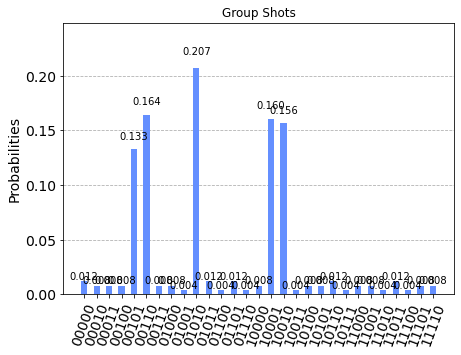

In [12]:
# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(qc, simulator, shots=256).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='Group Shots')

In [13]:
comb_res = extract_result(counts)
group_res = [ comb_to_group(comb, list(person_order)) for comb in comb_res ]
print(group_res)

['CH', 'DH', 'CE', 'DE', 'DF']
